In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
preprocessed_list = qs::qread('preprocessed_list.qs')
outliers_list = qs::qread('outliers_list.qs')

In [3]:
outliers_tbl <- outliers_list %>% 
  enframe(name = "Name", value = "Sample") %>%
  unnest(Sample) %>%
  rename(name = Sample, failed = Name)

outliers_tbl

failed,name
<chr>,<chr>
names_failing_star_qc,S0010_04_chow_HPF
names_failing_star_qc,S0010_12_fast_HY
names_failing_star_qc,S0010_11_fast_HPF
names_failing_star_qc,S0010_10_fast_SC
names_failing_star_qc,S0037_1441_chow_HY
names_failing_star_qc,S0038_1422_chow_HY
names_failing_star_qc,S0038_1451_chow_HY
names_failing_star_qc,S0038_1431_chow_HPF
names_failing_star_qc,S0038_1441_chow_HPF


In [4]:
do_regional_pca_plot = function(preprocessed_list, plot_title){
    pca = preprocessed_list[[plot_title]]$pca
    meta_f = preprocessed_list[[plot_title]]$meta_f
    meta_f$duration = round(meta_f$experiment_duration)
    meta_f$duration = as.character(meta_f$duration)
    
    # Get the proportion of variance explained by each PC
    var_explained <- pca$sdev^2 / sum(pca$sdev^2) * 100 

    # Create a data frame from the prcomp output and add the meta_f data
    df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], meta_f)

    # Define colors and shapes manually for diet and PCA_zregion_outlier
    color_manual <- scale_color_manual(values = c("HFD" = "#1A85FF", "chow" = "black", "fast" = "#D41159"))
    shape_manual <- scale_shape_manual(values = c("16" = 21, "24" = 19)) #1 for 'empty circle' and 19 for 'filled circle'
    # Create the scatter plot using ggplot2
    p = ggplot(df, aes(x = PC1, y = PC2, 
                     color = diet, 
                     shape = duration,
                     stroke = 0.5
                     )) +
  scale_x_continuous(expand = c(0.125, 0)) +  # No expansion for x axis
  scale_y_continuous(expand = c(0.125, 0)) +   # No expansion for y axis
      shape_manual +
      geom_point(size = 0.8) +  # Increase the point size and the outline thickness
      color_manual + 
#       shape_manual + 
      labs(
        x = paste0("PC1 (", round(var_explained[1], 2), "%)"), 
        y = paste0("PC2 (", round(var_explained[2], 2), "%)"), 
        color = "Diet"
      ) +
      annotate("text", x = min(df$PC1), y = max(df$PC2), label = str_split(plot_title, '_') %>% unlist %>% `[`(2), 
               hjust = -0.0000001, vjust = 0.0000001, size = 2, color = "black", fontface='bold') +
      theme_minimal() +  # apply a minimal theme
      theme(
        panel.grid.major = element_blank(),  # remove major gridlines
        panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), 
        axis.text = element_blank(), # remove minor gridlines
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.title = element_text(size = 6), # Make axes lines thicker and black,
        legend.text = element_text(size = 6),
          legend.spacing.x = unit(0.0000001, 'cm')
      )
    p
}

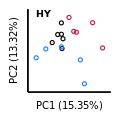

In [5]:
options(repr.plot.width=1, repr.plot.height=1)
preprocessed_selection = '0010_HY'
p1 = do_regional_pca_plot(preprocessed_list, preprocessed_selection)
p1 + theme(legend.position = "none")

In [6]:
# List of preprocessed selections
preprocessed_selections <- c("0010_HY", "0010_HPF", "0010_SC", 
                              "0010_IC", "0010_PFC", "0037_HY", 
                              "0037_HPF", "0037_SC", "0037_IC", 
                              "0037_ZI")

# Generate plots for each preprocessed selection and store them in a list
plot_list <- lapply(preprocessed_selections, function(selection) {
  do_regional_pca_plot(preprocessed_list, selection)
})

# Assign each plot to a variable p1 to p10
list2env(setNames(plot_list, paste0("p", seq_along(plot_list))), envir = .GlobalEnv)


<environment: R_GlobalEnv>

In [7]:
 p1 = p1 + ggtitle('16h') + theme(plot.title = element_text(size = 6, face = "bold", hjust = 0.5))
p6 = p6 + ggtitle('24h') + theme(plot.title = element_text(size = 6, face = "bold", hjust = 0.5))


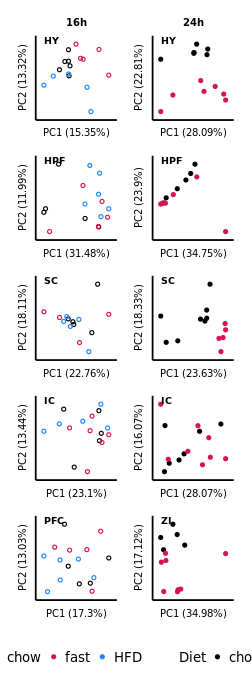

In [8]:
library(patchwork)
options(repr.plot.width=2.1, repr.plot.height=5.8)
# Combine plots into a patchwork
combined_plot = (p1 / p2 / p3 / p4 / p5) | (p6 / p7 / p8 / p9 / p10)
# Consolidate all legends into one and place it at the bottom
combined_plot = combined_plot + plot_layout(guides = 'collect')  & 
  theme(legend.position = "bottom",  # Move legend to bottom
        legend.text = element_text(size = 8),  # Resize legend text
        legend.key.size = unit(0.5, "cm"),
        legend.title = element_text(size = 8),)  # Resize legend keys
combined_plot = combined_plot + ggtitle('B') + theme(plot.title = element_text(size = 6, face = "bold", hjust = 0.5))
combined_plot

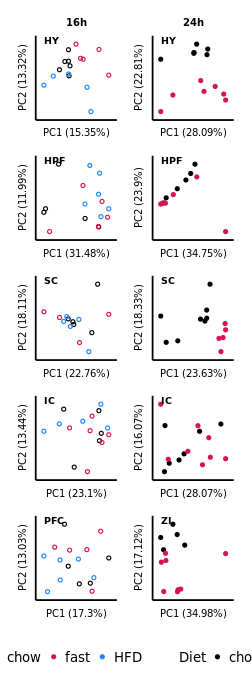

In [9]:
# Consolidate all legends into one and place it at the bottom
combined_plot + plot_layout(guides = 'collect') & theme(legend.position = "bottom") 

In [10]:
do_all_region_pca_plot = function(preprocessed_list, plot_title){
    pca = preprocessed_list[[plot_title]]$pca
    meta_f = preprocessed_list[[plot_title]]$meta_f
    meta_f$duration = round(meta_f$experiment_duration)

    # Get the proportion of variance explained by each PC
    var_explained <- pca$sdev^2 / sum(pca$sdev^2) * 100 

    # Create a data frame from the prcomp output and add the meta_f data
    df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], meta_f)

    # Define colors and shapes manually for region and duration
    color_manual <- scale_color_manual(values = c("HY" = "#CC6677", "HPF" = "#117733", 
                                                  "PFC" = "#999933", "IC" = "#88CCEE", 
                                                  "SC" = "#332288", "ZI" = "#AA4499"))
    shape_manual <- scale_shape_manual(values = c("16" = 21, "24" = 19)) #1 for 'empty circle' and 19 for 'filled circle'

    # Create the scatter plot using ggplot2
    p = ggplot(df, aes(x = PC1, y = PC2, 
                     color = region, 
                     shape = as.character(duration),
                     )) + 
      geom_point(size = 0.8, stroke=0.5) +  # Increase the point size and the outline thickness
      color_manual + 
      shape_manual + 
      geom_text(data = df[df$PCA_zregion_outlier == TRUE, ], aes(label = 'x'), size = 3, color = "red") +
      labs(
        x = paste0("PC1 (", round(var_explained[1], 2), "%)"), 
        y = paste0("PC2 (", round(var_explained[2], 2), "%)"), 
        color = "Region", 
        shape = "Duration"
      ) +
      theme_minimal() +  # apply a minimal theme
      theme(
        panel.grid.major = element_blank(),  # remove major gridlines
        panel.grid.minor = element_blank(),  # remove minor gridlines
        axis.line = element_line(color = "black", size = 0.5),
        axis.ticks = element_blank(), 
        axis.text = element_blank(), # remove minor gridlines# Make axes lines thicker and black
        axis.title = element_text(size = 6),
        legend.text = element_text(size = 6),
        legend.position = "bottom",
        legend.spacing.x = unit(0.0000001, 'cm'),
        legend.title = element_text(size = 8),
      )
    p
}


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


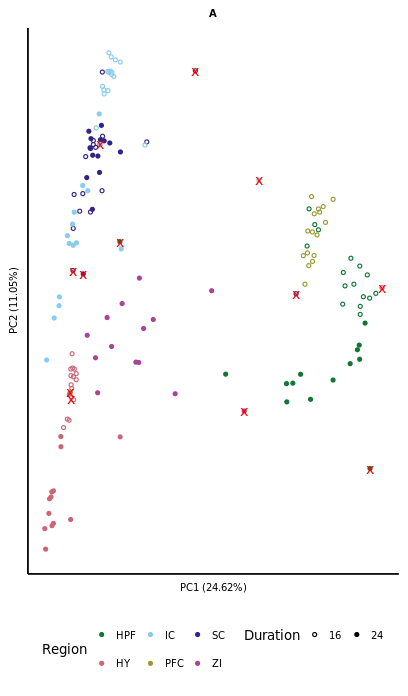

In [11]:
options(repr.plot.width=3.4, repr.plot.height=5.8)
p_all_regions = do_all_region_pca_plot(preprocessed_list, 'names_failing_all_region_pca_qc') 
p_all_regions = p_all_regions + ggtitle('A') + theme(plot.title = element_text(size = 6, face = "bold", hjust = 0.5))
p_all_regions

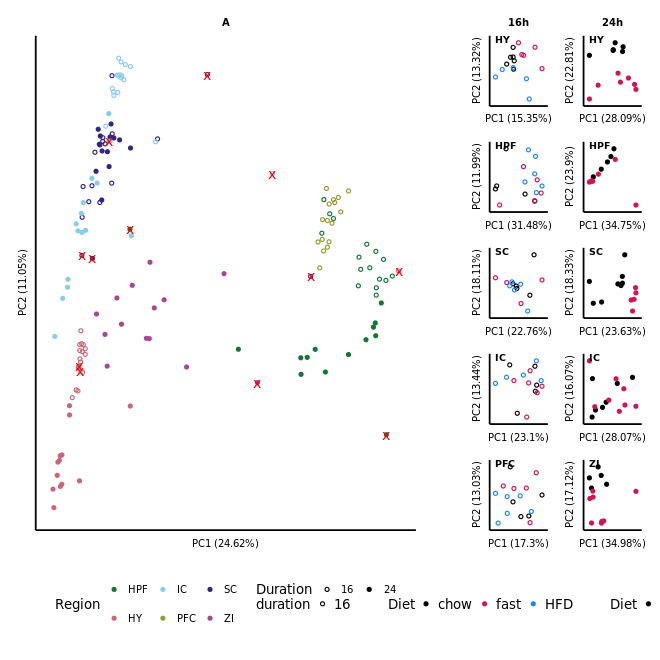

In [12]:
options(repr.plot.width=5.5, repr.plot.height=5.5)
layout <- "
AAAAAAAAAA#BBBB
AAAAAAAAAA#BBBB
AAAAAAAAAA#BBBB
AAAAAAAAAA#BBBB
AAAAAAAAAA#BBBB
" 

p_all_regions = p_all_regions + ggtitle('A') + theme(plot.title = element_text(size = 6, face = "bold", hjust = 0.5))
combined_plot = combined_plot + ggtitle('B') + theme(plot.title = element_text(size = 6, face = "bold", hjust = 0.5))

p_all_pca = p_all_regions + combined_plot + plot_layout(design = layout)
p_all_pca

In [13]:
ggsave("p_all_pca.pdf", plot = p_all_pca, width = 5.5, height = 5.5)


In [14]:
meta_qc = qs::qread('meta_qc.qs')

sample_order <- meta_qc %>%
distinct(animal_id, seq_run, diet) %>%
arrange(seq_run, diet, animal_id) %>%
select(seq_run, diet, animal_id) %>%
distinct(animal_id) %>%
pull(animal_id) %>% as.character
sample_order

meta_qc = meta_qc %>% 
mutate(animal_id = factor(animal_id, levels=sample_order))

[1] "13"   "14"   "15"   "16"   "17"   "18"   "1"    "2"    "3"    "4"   
[11] "5"    "6"    "7"    "8"    "9"    "10"   "11"   "12"   "1422" "1423"
[21] "1431" "1432" "1441" "1442" "1443" "1451" "1452" "1424" "1425" "1433"
[31] "1434" "1435" "1444" "1445" "1453" "1454" "1455"

Rows: 38 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): diet, notes
dbl  (14): box_id, animal_id, diet_kcal, experiment_duration, bw_i_pre, bw_i...
dttm  (2): experiment_start, time_of_euthanasia

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "13"   "14"   "15"   "16"   "17"   "18"   "1"    "2"    "3"    "4"   
[11] "5"    "6"    "10"   "11"   "12"   "7"    "8"    "9"    "1421" "1422"
[21] "1423" "1431" "1432" "1441" "1442" "1443" "1451" "1452" "1424" "1425"
[31] "1433" "1434" "1435" "1444" "1445" "1453" "1454" "1455"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


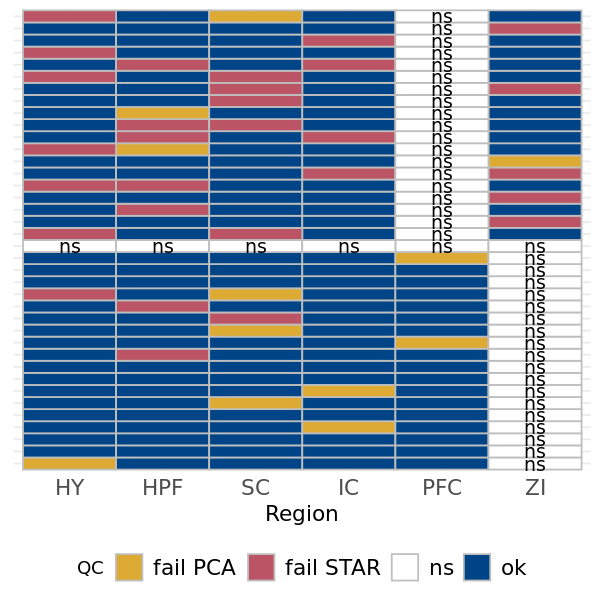

In [15]:
# Convert the name column to a factor with the desired order
meta_animal = read_csv('../03_build_meta_and_counts/meta_animal.csv')
meta_animal$animal_id <- as.character(meta_animal$animal_id)

meta_animal = meta_animal %>%
mutate(animal_id = as.character(animal_id)) %>%
rowwise %>%
mutate(animal_id = replace_na(animal_id, as.character(box_id))) %>%
ungroup



all_animal_ids = meta_animal %>% pull(animal_id) %>% c("1421")
# Create a new tibble
new_tibble <- tibble(
  animal_id = all_animal_ids,
  region = ifelse(nchar(all_animal_ids) < 4, 'ZI', 'PFC'),
  qc = 'ns'
)
# Define the regions
regions <- c("HY", "HPF", "SC", "IC", "PFC", "ZI")
# Create a tibble for animal_id '1421'
tibble_1421 <- tibble(
  animal_id = rep('1421', length(regions)),
  region = regions,
  qc = 'ns'
)
# Combine the two tibbles
missing_sample_tib <- bind_rows(new_tibble, tibble_1421) %>% distinct

meta_qc_missing = meta_animal %>%
left_join(missing_sample_tib, by = 'animal_id')


meta_qc = meta_qc %>% bind_rows(meta_qc_missing)

meta_qc = meta_qc %>%
mutate(animal_id = as.character(animal_id)) %>%
mutate(region = factor(region, levels=c("HY", 'HPF', 'SC', 'IC', 'PFC', 'ZI'))) %>%
mutate(seq_run = ifelse(animal_id == '1421', '0037', seq_run))

options(repr.plot.width=5, repr.plot.height=5)
# Define the order of samples for the y-axis

sample_order <- meta_qc %>%
distinct(animal_id, seq_run, diet) %>%
arrange(seq_run, diet, animal_id) %>%
select(seq_run, diet, animal_id) %>%
distinct(animal_id) %>%
pull(animal_id) %>% na.omit
sample_order

meta_qc = meta_qc %>%
mutate(animal_id = factor(animal_id, levels=sample_order)) %>%
arrange(animal_id)

# Map the categorical variables to the plot
plot <- ggplot(meta_qc, aes(x = region, y = animal_id, fill = qc)) +
  geom_tile(color = "gray", size = 0.5) +
  scale_fill_manual(values = c("ok" = "#004488",
                               "fail STAR" = "#BB5566",
                               "fail PCA" = "#DDAA33",
                               "ns" = "#FFFFFF")) +
  scale_y_discrete(limits = sample_order) +
  labs(x = "Region", y = "Sample", fill = "QC") +
  geom_text(aes(label = ifelse(qc == "ns", "ns", "")), color = "black", size = 4) +
  theme_minimal() +
  theme(axis.text = element_text(size=13),
        axis.title.x = element_text(size=13),
        axis.title.y = element_blank(), 
        axis.text.y = element_blank(),
        legend.text = element_text(size = 13),
        legend.position = "bottom"
#         legend.position = "none")
        )
plot

In [16]:
meta_qc %>% group_by(seq_run) %>% summarise(n=n())

seq_run,n
<chr>,<int>
0010,90
0037,77
0038,24
NA,37


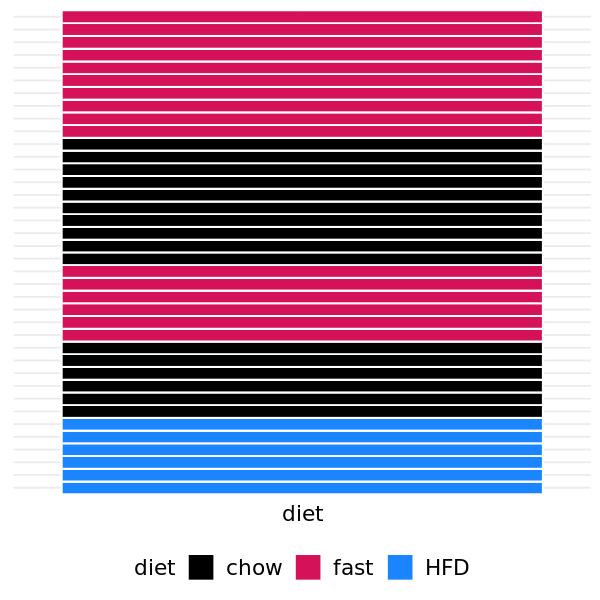

In [17]:
# Map the categorical variables to the plot
plot_diet <- meta_qc %>%
    mutate(dummy = 'diet') %>% 
  ggplot(aes(x = dummy, y = animal_id, fill = diet)) +
  geom_tile(color = "white", size = 0.5) +
  scale_fill_manual(values = c("HFD" = "#1A85FF", "chow" = "black", "fast" = "#D41159")) +
  scale_y_discrete(limits = sample_order) +
  labs(x = "diet", y = "Sample", fill = "diet") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), 
        axis.title.x = element_text(size=13),
        axis.text = element_blank(),
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 13),
        legend.position = "bottom"
#         legend.position = "none")
        )
plot_diet

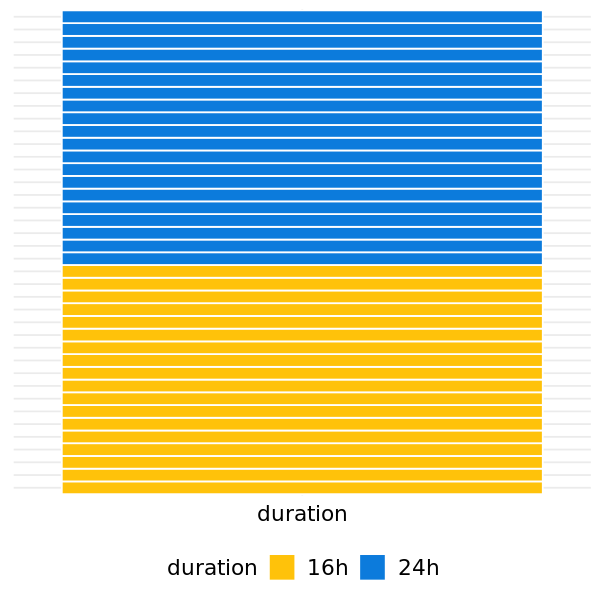

In [18]:
# Map the categorical variables to the plot
plot_time <- meta_qc %>%
    mutate(duration = case_when(seq_run == '0010' ~ '16h',
                                seq_run == '0037' ~ '24h')) %>% 
  mutate(dummy = 'duration') %>%
  distinct(animal_id, dummy, duration) %>%
  filter(!is.na(duration)) %>%
  distinct(animal_id, dummy, duration) %>%
  ggplot(aes(x = dummy, y = animal_id, fill = duration)) +
  geom_tile(color = "white", size = 0.5) +
  scale_fill_manual(values = c("16h" = "#FFC20A", "24h" = "#0C7BDC")) +
  scale_y_discrete(limits = sample_order) +
  labs(x = "duration", y = "Sample", fill = "duration") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), 
        axis.title.x = element_text(size=13),
        axis.text = element_blank(),
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 13),
        legend.position = "bottom"
#         legend.position = "none")
        )
plot_time

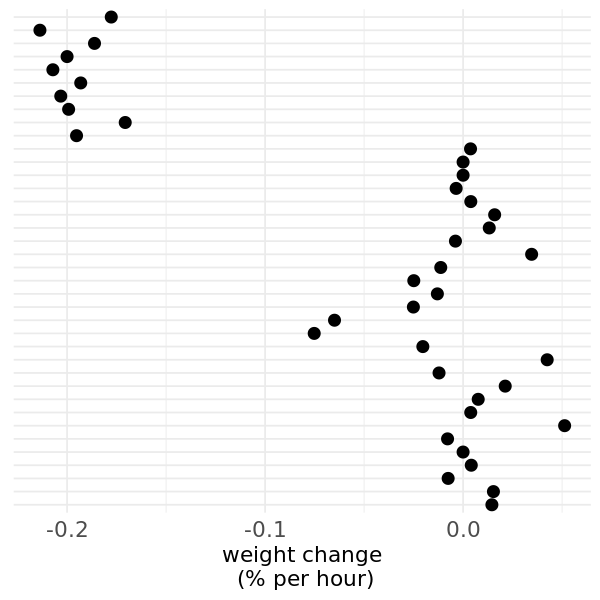

In [19]:

# Create the dot plot
plot_2 = ggplot(meta_animal, aes(y = animal_id, x = bw_change_pct)) +
  geom_point(size=3) +
  scale_y_discrete(limits = sample_order) +
  labs(x = "weight change\n (% per hour)", y = "Samples") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), 
        axis.title.x = element_text(size=13),
        axis.text.x = element_text(size=13),
        axis.text.y = element_blank(), 
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 13),
        legend.position = "none"
        )

plot_2

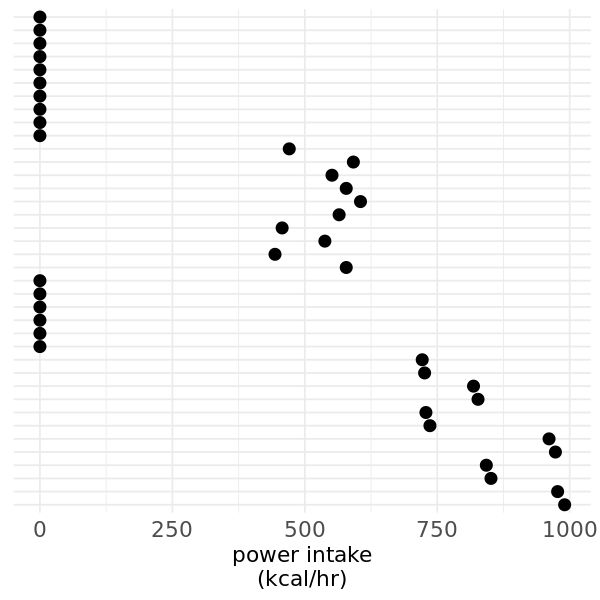

In [20]:
# Convert the name column to a factor with the desired order
meta_animal$animal_id <- factor(meta_animal$animal_id, levels = sample_order)

# Create the dot plot
plot_3 = ggplot(meta_animal, aes(y = animal_id, x = power_intake)) +
  geom_point(size=3) +
  scale_y_discrete(limits = sample_order) +
  labs(x = "power intake\n(kcal/hr)", y = "Samples") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), 
        axis.title.x = element_text(size=13),
        axis.text.x = element_text(size=13),
        axis.text.y = element_blank(), 
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 13),
        legend.position = "none"
        )


plot_3

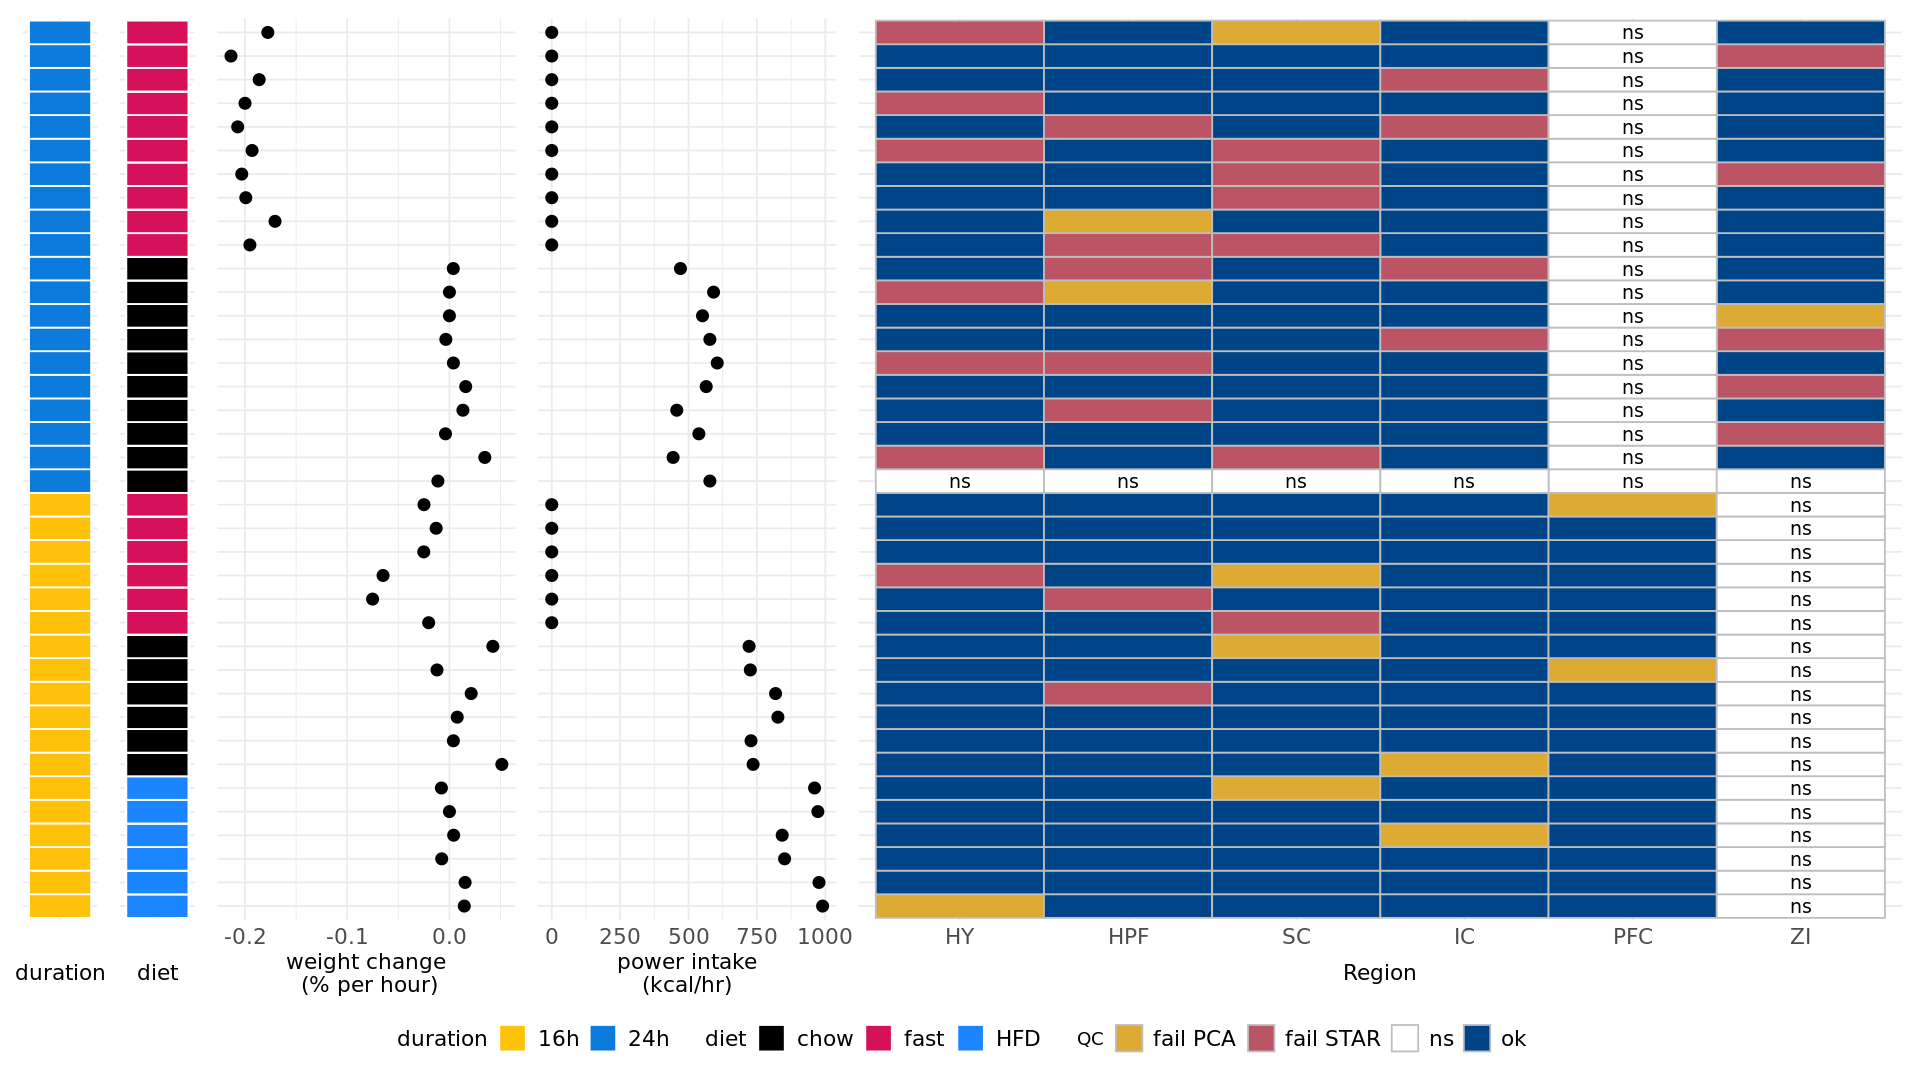

In [21]:
options(repr.plot.width=16, repr.plot.height=9)
layout <- "
ABCCCCDDDDEEEEEEEEEEEEEE
"
sample_plot = plot_time + plot_diet + plot_2 + plot_3 + plot + 
  plot_layout(design = layout) + plot_layout(guides = 'collect') & theme(legend.position = "bottom")
sample_plot %>% ggsave('sample_plot.pdf', plot=., width = 10, height = 6)
sample_plot